Height: 4, Aspect: 2


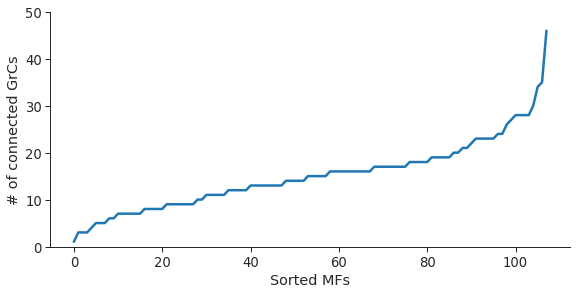

In [31]:
import collections
from collections import defaultdict
import sys
import json
import random
from jsmin import jsmin
from io import StringIO
import numpy as np
import copy
import importlib
from functools import partial
import math
import os
import compress_pickle

# script_n = os.path.basename(__file__).split('.')[0]
script_n = 'mf_size_210514_clustering'

sys.path.insert(0, '/n/groups/htem/Segmentation/shared-nondev/cb2_segmentation/analysis_mf_grc')
import my_plot
importlib.reload(my_plot)
from my_plot import MyPlotData

import tools_mf_graph
importlib.reload(tools_mf_graph)

fname = ('/n/groups/htem/Segmentation/shared-nondev/cb2_segmentation/analysis_mf_grc/'\
                                   'mf_grc_model/input_graph_210407_all.gz')
input_graph = compress_pickle.load(fname)

# z_min = 19800
# z_max = 29800
z_min = 19800-2500
z_max = 29800+2500
# GrCs are fully reconstructed and proofread from 90k to 150k
# MFs are fully reconstructed and proofread from 70k to 150k
# x_min = 100*1000*4
# x_max = 140*1000*4
x_min = 100*1000*4
x_max = 140*1000*4
# x_max = 115*1000*4
# x_max = 125*1000*4

pair_reps = defaultdict(int)

mfs_within_box = set()
mf_locs_within_box = set()
loc_to_mf = dict()

for mf_id, mf in input_graph.mfs.items():
    rosette_loc_size = {}
    mf.get_all_mf_locs_size(rosette_loc_size)
    for rosette_loc, size in rosette_loc_size.items():
        x, y, z = rosette_loc
        if x < x_min or x > x_max:
            continue
        if z < z_min or z > z_max:
            continue
        mfs_within_box.add(mf_id)
        mf_locs_within_box.add(rosette_loc)
        loc_to_mf[rosette_loc] = mf_id

# input_graph.randomize(preserve_mf_degree='soft')
# input_graph.randomize(preserve_mf_degree=False)

connected_grcs = set()
connected_grcs2 = list()
mf_connections = defaultdict(set)
mf_size = defaultdict(int)
for grc_id in input_graph.grcs:
    grc = input_graph.grcs[grc_id]
    connected_edge_count = 0
    for edge in grc.edges:
        mf_id, mf_loc = edge
        if mf_loc not in mf_locs_within_box:
            continue
        mf_connections[mf_id].add(grc_id)
        mf_size[mf_id] += 1
        connected_edge_count += 1
    if connected_edge_count:
        connected_grcs.add((grc_id, connected_edge_count))
        connected_grcs2.append(grc_id)
    
mf_size_sorted = []
for mf_id in mf_size:
    mf_size_sorted.append((mf_id, mf_size[mf_id]))
mf_size_sorted.sort(key=lambda x: x[1])

mpd_count = MyPlotData()
i = 0
for mf_id in mf_size_sorted:
    mf_id, size = mf_id
    mpd_count.add_data_point(
#         count=len(mf_connections[mf_id]),
        count=size,
        mf_id=i,
    )
    i += 1

importlib.reload(my_plot); my_plot.my_relplot(
    mpd_count,
    x='mf_id',
    y='count',
#     kind='hist',
    context='paper',
    linewidth=2.5,
    ylim=[0, 50],
#     kde=True,
#     stat='density',
    height=4,
    aspect=2,
    y_axis_label='# of connected GrCs',
    x_axis_label='Sorted MFs',
    save_filename=f'{script_n}_line.svg',
    show=True,
    )

In [35]:
grc_data_array = []
for grc_id in connected_grcs2:
    tmp = []
    for mf_id, _ in mf_size_sorted:
        if grc_id in mf_connections[mf_id]:
            tmp.append(1)
        else:
            tmp.append(0)
    grc_data_array.append(tmp)

In [32]:
mf_data_array = []
for mf_id, _ in mf_size_sorted:
    tmp = []
    for grc_id in connected_grcs2:
        if grc_id in mf_connections[mf_id]:
            tmp.append(1)
        else:
            tmp.append(0)
    mf_data_array.append(tmp)

In [36]:
mf_data_array[-1]
sum(grc_data_array[-2])

2

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


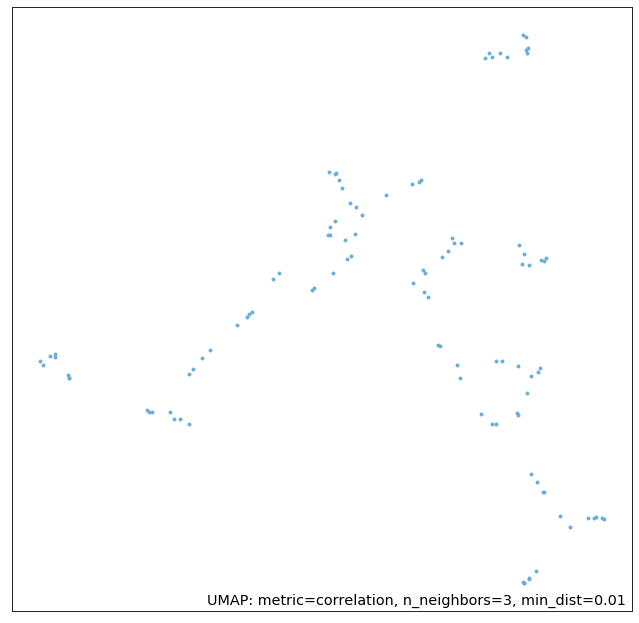

In [67]:
import umap
import umap.plot
mapper = umap.UMAP(
#     n_neighbors=100,
    n_neighbors=3,
    metric='correlation',
#     min_dist=.001,
    min_dist=.01,
#     min_dist=.1,
    ).fit(mf_data_array)
umap.plot.points(mapper)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


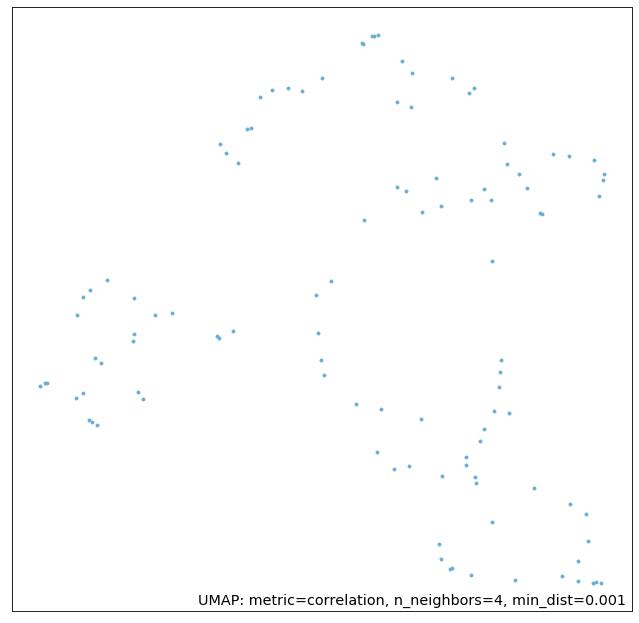

In [63]:
import umap
import umap.plot
mapper = umap.UMAP(
#     n_neighbors=100,
    n_neighbors=4,
    metric='correlation',
    min_dist=.001,
#     min_dist=.01,
#     min_dist=.1,
    ).fit(mf_data_array)
umap.plot.points(mapper)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


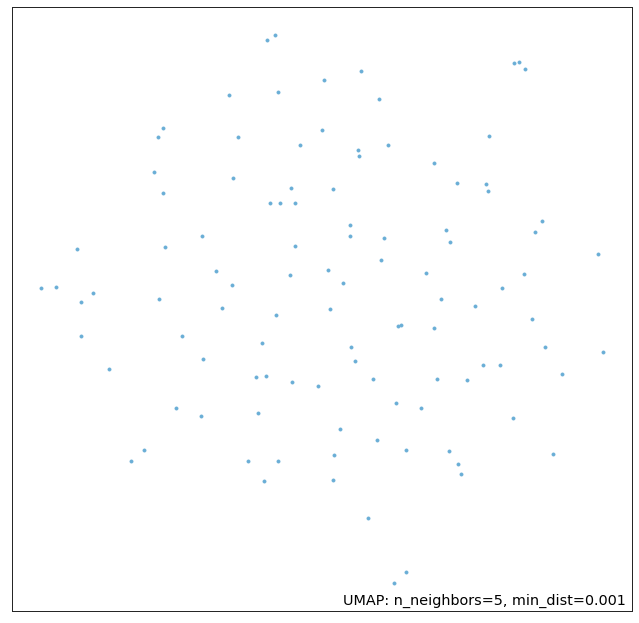

In [73]:
import umap
import umap.plot
mapper = umap.UMAP(
#     n_neighbors=100,
    n_neighbors=5,
#     metric='correlation',
#     min_dist=0,
    min_dist=.001,
#     min_dist=.01,
#     min_dist=.1,
    ).fit(mf_data_array)
umap.plot.points(mapper)

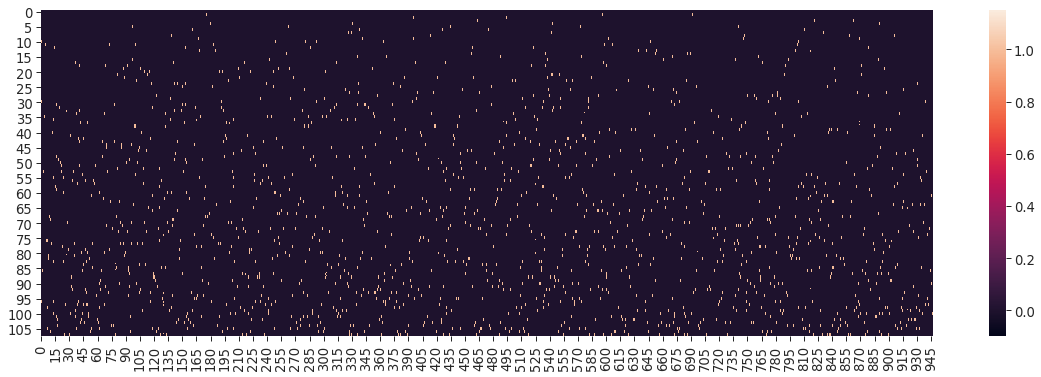

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
# sns.set_theme

# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(20, 6))
sns.heatmap(mf_data_array,
#             linewidths=.5,
            ax=ax,
            vmin=-.1, vmax=1.15,
#             cmap="YlGnBu",
           )

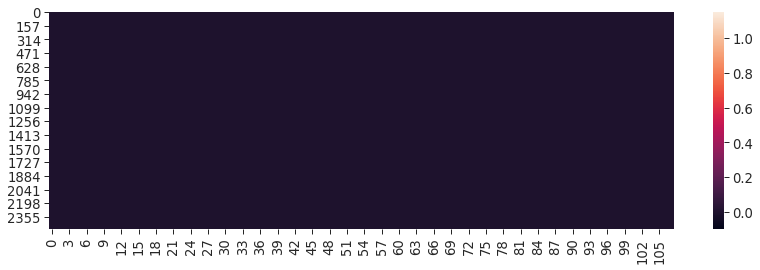

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
# sns.set_theme

# Draw a heatmap with the numeric values in each cell
# n = 4
n = 1
f, ax = plt.subplots(figsize=(14*n, 4*n))
sns.heatmap(plot_array,
#             linewidths=.5,
            ax=ax,
            vmin=-.1, vmax=1.15,
#             fontscale=4,
#             cmap="YlGnBu",
#             xticklabels=[],
#             yticklabels=[],
           )

plt.savefig(f'{script_n}.png', bbox_inches='tight', transparent=True)

Height: 4, Aspect: 2


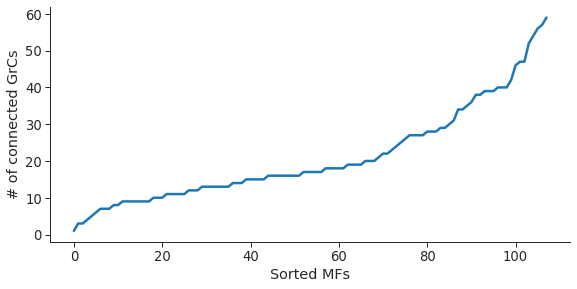

In [5]:

importlib.reload(my_plot); my_plot.my_relplot(
    mpd_count,
    x='mf_id',
    y='count',
#     kind='hist',
    context='paper',
    linewidth=2.5,
#     kde=True,
#     stat='density',
    height=4,
    aspect=2,
    y_axis_label='# of connected GrCs',
    x_axis_label='Sorted MFs',
    save_filename=f'{script_n}_line.svg',
    show=True,
    )

Height: 4, Aspect: 2


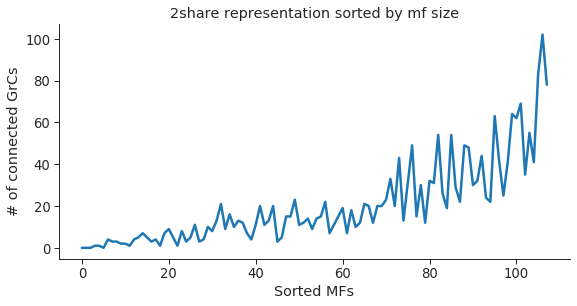

In [13]:

importlib.reload(my_plot); my_plot.my_relplot(
    mpd_count,
    x='mf_id',
    y='mf_2share',
#     kind='hist',
    context='paper',
    linewidth=2.5,
#     kde=True,
#     stat='density',
    height=4,
    aspect=2,
    y_axis_label='# of connected GrCs',
    x_axis_label='Sorted MFs',
    title='2share representation sorted by mf size',
    save_filename=f'{script_n}_line.svg',
    show=True,
    )

Height: 4, Aspect: 2


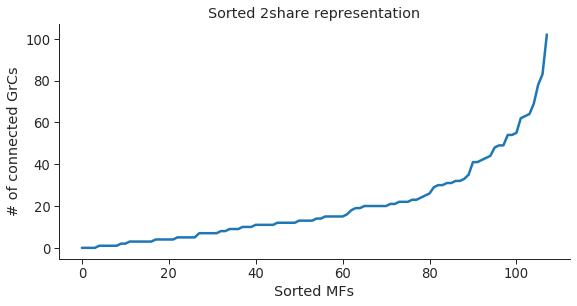

In [12]:

importlib.reload(my_plot); my_plot.my_relplot(
    mpd_count_2share,
    x='mf_id',
    y='mf_2share',
#     kind='hist',
    context='paper',
    linewidth=2.5,
#     kde=True,
#     stat='density',
    height=4,
    aspect=2,
    y_axis_label='# of connected GrCs',
    x_axis_label='Sorted MFs',
    title='2share representation sorted',
    save_filename=f'{script_n}_line.svg',
    show=True,
    )

Height: 4, Aspect: 2


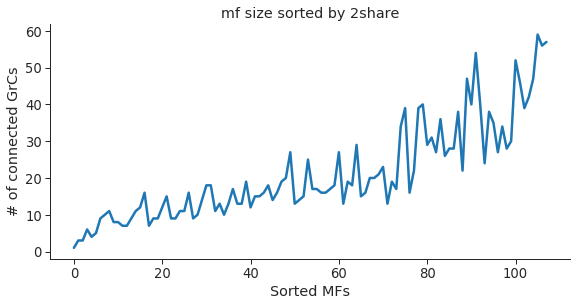

In [14]:

importlib.reload(my_plot); my_plot.my_relplot(
    mpd_count_2share,
    x='mf_id',
    y='count',
#     kind='hist',
    context='paper',
    linewidth=2.5,
#     kde=True,
#     stat='density',
    height=4,
    aspect=2,
    y_axis_label='# of connected GrCs',
    x_axis_label='Sorted MFs',
    title='mf size sorted by 2share',
    save_filename=f'{script_n}_line.svg',
    show=True,
    )

In [119]:
mf_size_sorted

[('mf_199', 1),
 ('mf_375', 3),
 ('mf_504', 4),
 ('mf_532', 6),
 ('mf_173', 7),
 ('mf_82', 9),
 ('mf_370', 9),
 ('mf_301', 9),
 ('mf_70', 9),
 ('mf_338', 10),
 ('mf_194', 10),
 ('mf_349', 10),
 ('mf_343', 11),
 ('mf_169', 11),
 ('mf_482', 11),
 ('mf_340', 13),
 ('mf_171', 13),
 ('mf_163', 13),
 ('mf_347', 13),
 ('mf_531', 13),
 ('mf_160', 13),
 ('mf_304', 13),
 ('mf_561', 14),
 ('mf_509', 15),
 ('mf_350', 15),
 ('mf_367', 15),
 ('mf_558', 16),
 ('mf_195', 16),
 ('mf_67', 16),
 ('mf_559', 16),
 ('mf_232', 16),
 ('mf_231', 17),
 ('mf_174', 17),
 ('mf_162', 17),
 ('mf_201', 18),
 ('mf_81', 18),
 ('mf_203', 19),
 ('mf_11', 20),
 ('mf_167', 20),
 ('mf_168', 20),
 ('mf_75', 21),
 ('mf_331', 22),
 ('mf_161', 24),
 ('mf_224', 27),
 ('mf_175', 27),
 ('mf_206', 27),
 ('mf_202', 28),
 ('mf_164', 28),
 ('mf_76', 30),
 ('mf_302', 31),
 ('mf_172', 36),
 ('mf_166', 38),
 ('mf_183', 39),
 ('mf_141', 39),
 ('mf_204', 40),
 ('mf_165', 46),
 ('mf_25', 47),
 ('mf_96', 56),
 ('mf_329', 57),
 ('mf_181', 59)

In [28]:
import itertools

grcs_edge_count = defaultdict(int)

def get_prob_2share(in_graph, count_within_box=True):
    shares = defaultdict(lambda: defaultdict(int))
#     processed = set()
#     total_n_pairs = 0
#     hist = defaultdict(int)
#     n = 0
    counted_grcs = 0
    for grc_i_id in in_graph.grcs:
        grc_i = in_graph.grcs[grc_i_id]
        if count_within_box:
            mf_ids = set([mf[0] for mf in grc_i.edges if mf[0] in mfs_within_box])
        else:
            mf_ids = set([mf[0] for mf in grc_i.edges if mf[0]])
        mf_ids = sorted(list(mf_ids))
        if len(mf_ids):
            grcs_edge_count[grc_i_id] = len(mf_ids)
#         print(mf_ids)
        for i in range(1, len(mf_ids)+1):
            for combination in itertools.combinations(mf_ids, i):
                shares[i][combination] += 1
#                 print(combination)
    return shares
                
#         if len(rosettes_i) == 0:
#             continue
#         if len(rosettes_i) == 1:
#             shares[1][mf_ids[0]]
#             continue
#         for grc_j_id in in_graph.grcs:
#             if grc_i_id == grc_j_id:
#                 continue
#             if unique_count and (grc_i_id, grc_j_id) in processed:
#                 continue
#             processed.add((grc_i_id, grc_j_id))
#             processed.add((grc_j_id, grc_i_id))
#             grc_j = in_graph.grcs[grc_j_id]
#             common_rosettes = set([mf[0] for mf in grc_j.edges])
#             common_rosettes = common_rosettes & rosettes_i
#             hist[len(common_rosettes)] += 1
#     for k in hist:
#         # fix 0 datapoint plots
#         if hist[k] == 0:
#             hist[k] = 1
#     if return_counted:
#         return hist, counted_grcs
#     else:
#         return hist

hist_data = get_prob_2share(input_graph)

# print(hist_data)
# n_grcs = len(input_graph.grcs)

In [22]:
def calc_distribution(hist):
    dist = defaultdict(lambda: defaultdict(int))
    dist_raw = defaultdict(list)
    for k in hist:
        for v in hist[k]:
            val = hist[k][v]
            dist[k][val] += 1
            dist_raw[k].append(val)
    return dist, dist_raw

dist, dist_raw = calc_distribution(hist_data)

In [48]:
for k in sorted(hist_data.keys()):
    pairs = list(hist_data[k].items())
    pairs.sort(key=lambda x: x[1])
    print(k)
    for pair in pairs:
        print(pair)

1
(('mf_199',), 1)
(('mf_375',), 3)
(('mf_504',), 4)
(('mf_532',), 6)
(('mf_173',), 7)
(('mf_82',), 9)
(('mf_370',), 9)
(('mf_301',), 9)
(('mf_70',), 9)
(('mf_338',), 10)
(('mf_194',), 10)
(('mf_349',), 10)
(('mf_343',), 11)
(('mf_169',), 11)
(('mf_482',), 11)
(('mf_340',), 13)
(('mf_171',), 13)
(('mf_163',), 13)
(('mf_347',), 13)
(('mf_531',), 13)
(('mf_160',), 13)
(('mf_304',), 13)
(('mf_561',), 14)
(('mf_509',), 15)
(('mf_350',), 15)
(('mf_367',), 15)
(('mf_558',), 16)
(('mf_195',), 16)
(('mf_67',), 16)
(('mf_559',), 16)
(('mf_232',), 16)
(('mf_231',), 17)
(('mf_174',), 17)
(('mf_162',), 17)
(('mf_201',), 18)
(('mf_81',), 18)
(('mf_203',), 19)
(('mf_11',), 20)
(('mf_167',), 20)
(('mf_168',), 20)
(('mf_75',), 21)
(('mf_331',), 22)
(('mf_161',), 24)
(('mf_224',), 27)
(('mf_175',), 27)
(('mf_206',), 27)
(('mf_202',), 28)
(('mf_164',), 28)
(('mf_76',), 30)
(('mf_302',), 31)
(('mf_172',), 36)
(('mf_166',), 38)
(('mf_183',), 39)
(('mf_141',), 39)
(('mf_204',), 40)
(('mf_165',), 46)
(('mf_

In [27]:
for share in dist:
    print(share)
    for v in sorted(dist[share].keys()):
        print(f'{v}: {dist[share][v]}')

1
1: 1
3: 1
4: 1
6: 1
7: 1
9: 4
10: 3
11: 3
13: 7
14: 1
15: 3
16: 5
17: 3
18: 2
19: 1
20: 3
21: 1
22: 1
24: 1
27: 3
28: 2
30: 1
31: 1
36: 1
38: 1
39: 2
40: 1
46: 1
47: 1
56: 1
57: 1
59: 1
2
1: 201
2: 70
3: 33
4: 7
5: 2
3
1: 122
2: 2
4
1: 21
5
1: 2


In [42]:
print(len(mfs_within_box))
print(len(grcs_edge_count))
s = 0
for k, v in grcs_edge_count.items():
    if v >= 2:
        s += 1
print(s)

60
867
281


In [39]:
# shuffle the graph and see how it affects distribution
shuffled_shares = defaultdict(lambda: defaultdict(int))
mfs_within_box = list(mfs_within_box)
for grc_id, count in grcs_edge_count.items():
    mf_ids = []
    for i in range(count):
        mf_ids.append(random.choice(mfs_within_box))
    mf_ids = list(set(mf_ids))
    for i in range(1, len(mf_ids)+1):
        for combination in itertools.combinations(mf_ids, i):
            shuffled_shares[i][combination] += 1
            
shuffle_dist, shuffle_dist_raw = calc_distribution(shuffled_shares)

In [40]:
for share in shuffle_dist:
    print(share)
    for v in sorted(shuffle_dist[share].keys()):
        print(f'{v}: {shuffle_dist[share][v]}')

1
9: 1
10: 1
13: 2
14: 1
15: 2
16: 4
17: 4
18: 6
19: 7
20: 4
21: 3
22: 2
23: 9
24: 2
25: 3
26: 4
27: 1
28: 1
29: 1
30: 1
33: 1
2
1: 363
2: 47
3: 3
3
1: 118
2: 2
4
1: 21
5
1: 2


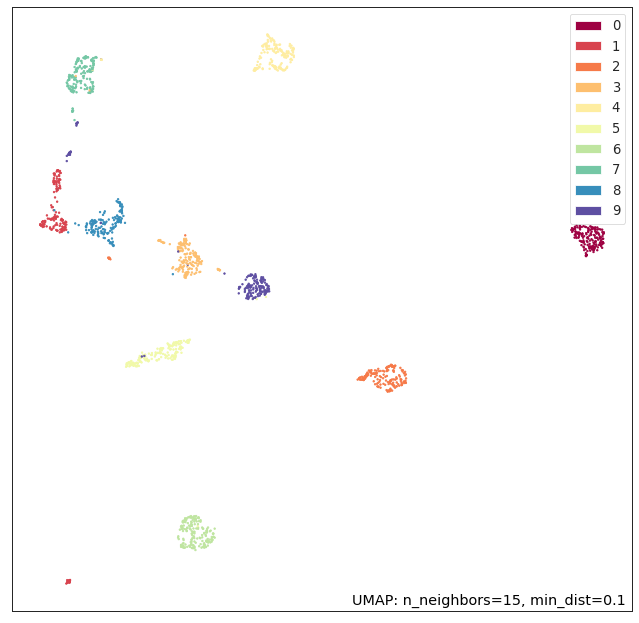

In [11]:
import umap
import umap.plot
from sklearn.datasets import load_digits

digits = load_digits()

mapper = umap.UMAP().fit(digits.data)
umap.plot.points(mapper, labels=digits.target)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


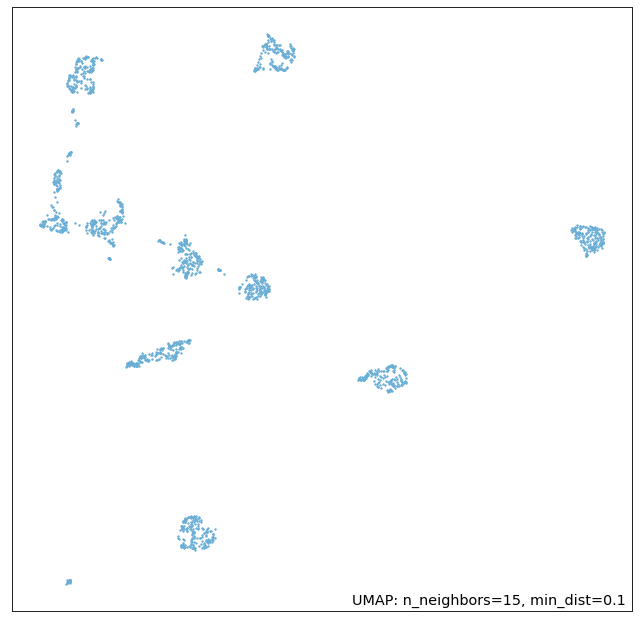

In [12]:
umap.plot.points(mapper)